# Autoencoder for the MNIST dataset in Tensorflow

Importing some libraries, also the mnist dataset is preprocessed in the tensorflow tutorial libraries.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import tensorflow as tf
from time import time
import numpy as np
import matplotlib.pyplot as plt

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


 Defining some functions we will be using later on.

In [2]:
# predefined functions to add noise to initial values of weights and biases
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# predefined conv and pool layers with stride and padding set
def conv2d(x, W): 
    return tf.nn.conv2d(x, filter=W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# predefined transposed convolution layer
def conv2d_transposed(x, filters): 
    return tf.layers.conv2d_transpose(inputs=x, filters=filters, 
                                      kernel_size=[2, 2], strides=[2, 2], padding='SAME')


def addNoise(pixels):
    """ Takes an input batch and adds some random noise to each pixel."""
    pixels += np.random.normal(loc=0.2, scale=0.1, size=pixels.shape) 
    return np.clip(pixels, 0, 1)

## Building the main architecture

First we will define an encoder and a decoder and then build the autoencoder from both of them together.

In [3]:
def encoder(input_images):
    """ 
    An encoder using convolutional layers to compress the images from a shape of 28x28x1 to 7x7x2.
    """
    with tf.name_scope('reshaping'):
        x_reshaped = tf.reshape(input_images, [-1, 28, 28, 1])

    
    # convolutional layer, result shape: 28x28, 8 filters
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([3, 3, 1, 8])
        b_conv1 = bias_variable([8])
        h_conv1 = tf.nn.relu(conv2d(x_reshaped, W_conv1) + b_conv1)


    # max pool layer, result shape: 14x14, 8 filters
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)


    # convolutional layer, result shape: 14x14, 4 filters
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([3, 3, 8, 4])
        b_conv2 = bias_variable([4])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)


    # max pool layer, result shape: 7x7, 4 filters
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)


    # convolutional layer, result shape: 7x7, 2 filters
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([3, 3, 4, 2])
        b_conv3 = bias_variable([2])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        
    return h_conv3

In [4]:
def decoder(input_compressions):
    """ 
    An decoder using tansposed convolutional layers rebuild images from a 
    resolution of 7x7x2 back up to 28x28x1.
    """
    
    # do a transposed convolution to start increasing the features again
    # result shape: 14x14, 4 filters
    with tf.name_scope('trans_conv1'):
        h_trans_conv1 = conv2d_transposed(input_compressions, 4)


    # convolutional layer, result shape: 14x14, 4 filters
    with tf.name_scope('conv4'):
        W_conv4 = weight_variable([3, 3, 4, 4])
        b_conv4 = bias_variable([4])
        h_conv4 = tf.nn.relu(conv2d(h_trans_conv1, W_conv4) + b_conv4)


    # transposed convolutional layer, result shape: 28x28, 8 filters
    with tf.name_scope('trans_conv2'):
        h_trans_conv2 = conv2d_transposed(h_conv4, 8)


    # convolutional layer, result shape: 28x28, 8 filters
    with tf.name_scope('conv5'):
        W_conv5 = weight_variable([3, 3, 8, 8])
        b_conv5 = bias_variable([8])
        h_conv5 = tf.nn.relu(conv2d(h_trans_conv2, W_conv5) + b_conv5)


    # output convolutional layer, result shape: 28x28, 1 filter
    with tf.name_scope('outconv'):
        W_out_conv = weight_variable([1, 1, 8, 1])
        b_out_conv = bias_variable([1])
        h_out_conv = tf.nn.relu(conv2d(h_conv5, W_out_conv) + b_out_conv)
        
   
    return h_out_conv

In [5]:
def autoencoder(input_images):
    return decoder(encoder(input_images))

Now we can build a class to build, train and test an autoencoder, aswell as printing some of the predictions.

In [6]:
def testAutoencoder(learning_rate, epochs, num_predictions_print, test_noise=False):
    print("Building and training an autoencoder with learning rate " + str(learning_rate))
    # Placeholder for input
    x = tf.placeholder(tf.float32, [None, 28*28])

    # Placeholder for output
    y = autoencoder(x)
    y_flat = tf.reshape(y, [-1, 28*28])

    # Calculate loss from original image
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.square(y_flat - x))
        tf.summary.scalar('loss', loss)

    with tf.name_scope("AdamOptimizer"):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    merged_summary_op = tf.summary.merge_all()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('C:/Users/Kai/Desktop/Logs/Exercise3/' + str(learning_rate), graph=sess.graph)
        for epoch in range(epochs):
                batch_train = mnist.train.next_batch(64)
                batch_test = mnist.train.next_batch(64)
                if epoch % 500 == 0:
                    train_loss = loss.eval(feed_dict={x: batch_train[0]})
                    test_loss = loss.eval(feed_dict={x: batch_test[0]})
                    print('step %d, training loss %g, validation set loss %g' % (epoch, train_loss, test_loss))
                train_step.run(feed_dict={x: batch_train[0]})

                # collect data for summary
                summary_str = sess.run(merged_summary_op, feed_dict={x: batch_train[0]})
                writer.add_summary(summary_str, epoch)
        
        # Feed in the validation data in smaller batches
        validation_loss = 0
        for _ in range(5):
            batch_validation = mnist.validation.next_batch(1000)
            validation_loss += loss.eval(feed_dict={x: batch_validation[0]})
        validation_loss /= 5
        print('validation loss  in fully trained net: %g' % (validation_loss))
                
            
        # print out some examples
        for i in range(num_predictions_print):
            label = [mnist.validation.next_batch(1)[0][0], ]
            label_pixels = np.array(label).reshape((28, 28))
            plt.title('Original image')
            plt.imshow(label_pixels, cmap='gray')
            plt.show()
            
            prediction = y.eval(feed_dict={x: label})
            pixels = np.array(prediction).reshape((28, 28))
            plt.title('Prediction')
            plt.imshow(pixels, cmap='gray')
            plt.show()
            
            if test_noise:
                # Add some noise onto pictures and predict them aswell
                label_pixels_noise = addNoise(label_pixels)
                plt.title('Original image with noise')
                plt.imshow(label_pixels_noise, cmap='gray')
                plt.show()

                
                noisy_input = [label_pixels_noise.reshape((28*28,)), ]
                prediction = y.eval(feed_dict={x: noisy_input})
                pixels = np.array(prediction)
                pixels = pixels.reshape((28, 28))
                plt.title('Prediction of noisy image')
                plt.imshow(pixels, cmap='gray')
                plt.show()

            
    tf.reset_default_graph()            

Now lets train the autoencoder and look at some of it's predictions, with and without noise. 

Building and training an autoencoder with learning rate 0.1
step 0, training loss 0.106148, validation set loss 0.0945133
step 500, training loss 0.0950001, validation set loss 0.0866601
step 1000, training loss 0.096987, validation set loss 0.0887286
step 1500, training loss 0.0911647, validation set loss 0.101443
step 2000, training loss 0.0900802, validation set loss 0.0897723
step 2500, training loss 0.0916787, validation set loss 0.0866556
step 3000, training loss 0.0867544, validation set loss 0.0913335
step 3500, training loss 0.0924069, validation set loss 0.0948624
step 4000, training loss 0.106859, validation set loss 0.111425
step 4500, training loss 0.102569, validation set loss 0.117515
step 5000, training loss 0.107831, validation set loss 0.110831
step 5500, training loss 0.109755, validation set loss 0.10782
step 6000, training loss 0.109839, validation set loss 0.105632
step 6500, training loss 0.107675, validation set loss 0.116816
step 7000, training loss 0.111571, v

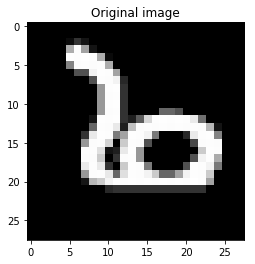

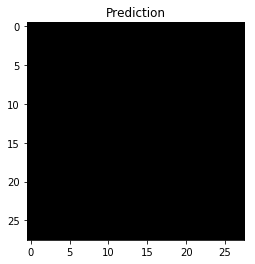

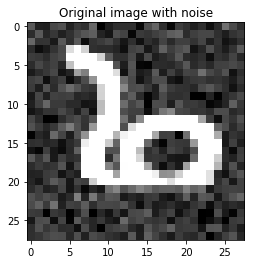

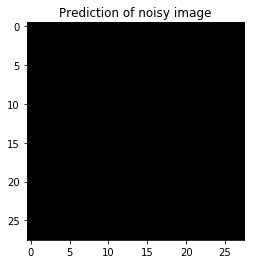

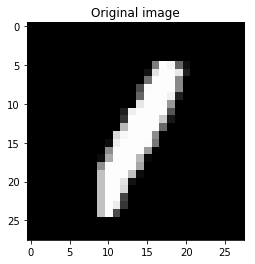

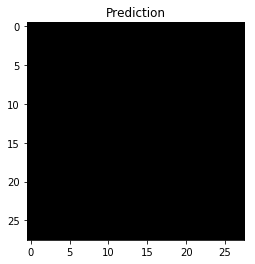

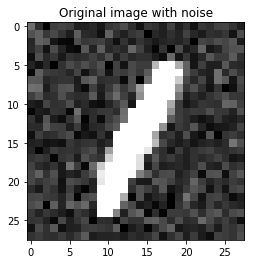

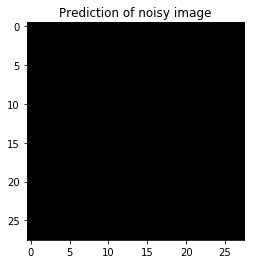

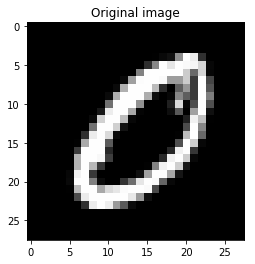

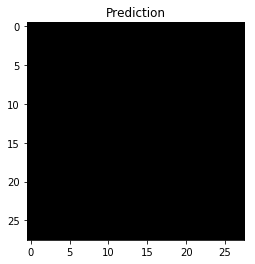

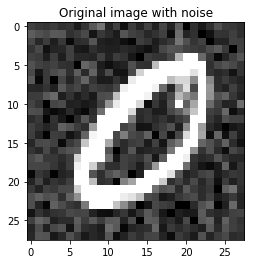

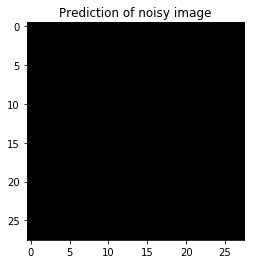

Building and training an autoencoder with learning rate 0.01
step 0, training loss 0.0946914, validation set loss 0.0922705
step 500, training loss 0.00958354, validation set loss 0.010013
step 1000, training loss 0.00819387, validation set loss 0.00812647
step 1500, training loss 0.00761954, validation set loss 0.00761962
step 2000, training loss 0.00776708, validation set loss 0.00831562
step 2500, training loss 0.00784816, validation set loss 0.00790562
step 3000, training loss 0.00767135, validation set loss 0.00662788
step 3500, training loss 0.0070076, validation set loss 0.00758108
step 4000, training loss 0.00734221, validation set loss 0.00756246
step 4500, training loss 0.00709106, validation set loss 0.00602656
step 5000, training loss 0.00706401, validation set loss 0.00773085
step 5500, training loss 0.00686963, validation set loss 0.00770896
step 6000, training loss 0.00699749, validation set loss 0.00663225
step 6500, training loss 0.00710821, validation set loss 0.00684

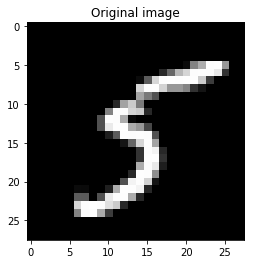

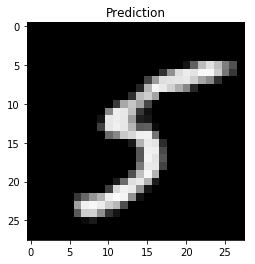

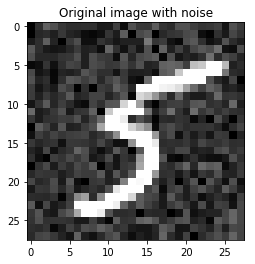

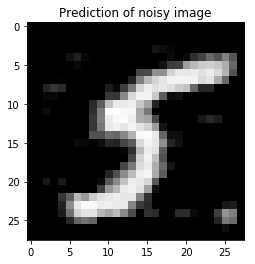

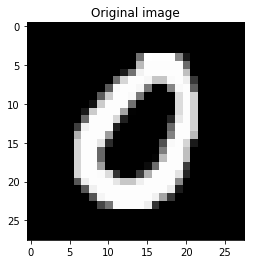

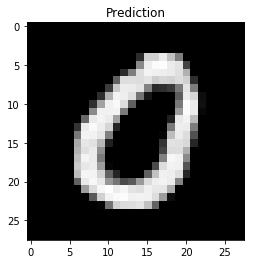

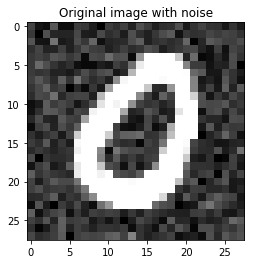

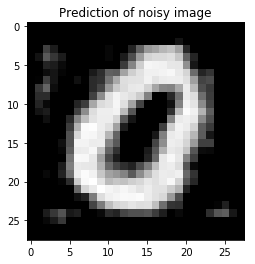

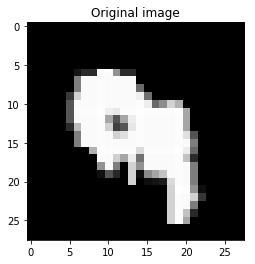

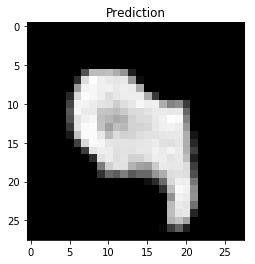

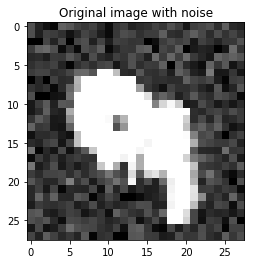

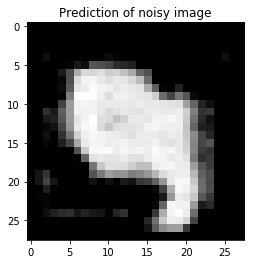

Building and training an autoencoder with learning rate 0.001
step 0, training loss 0.09136, validation set loss 0.0950463
step 500, training loss 0.0127879, validation set loss 0.0145017
step 1000, training loss 0.0116727, validation set loss 0.0105188
step 1500, training loss 0.00929025, validation set loss 0.00952843
step 2000, training loss 0.00808866, validation set loss 0.00909748
step 2500, training loss 0.00815181, validation set loss 0.00850892
step 3000, training loss 0.00788539, validation set loss 0.00727374
step 3500, training loss 0.00745397, validation set loss 0.00734314
step 4000, training loss 0.00708272, validation set loss 0.00758822
step 4500, training loss 0.00696849, validation set loss 0.00730001
step 5000, training loss 0.00747443, validation set loss 0.00673655
step 5500, training loss 0.00692964, validation set loss 0.00708788
step 6000, training loss 0.00684464, validation set loss 0.00691944
step 6500, training loss 0.00644485, validation set loss 0.0063620

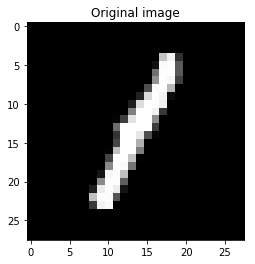

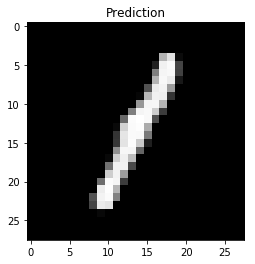

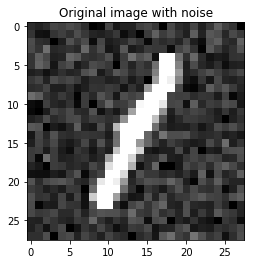

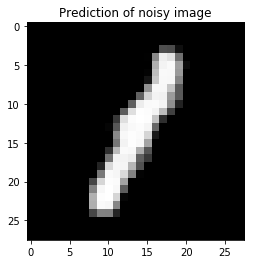

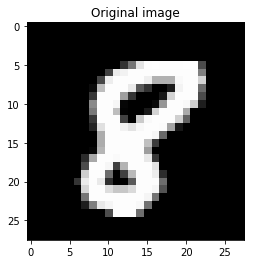

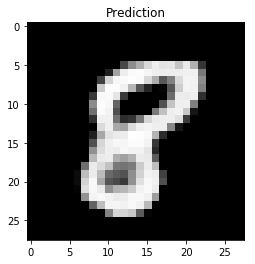

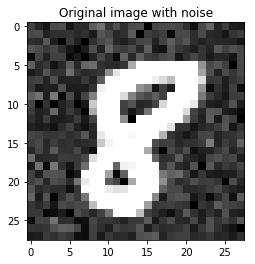

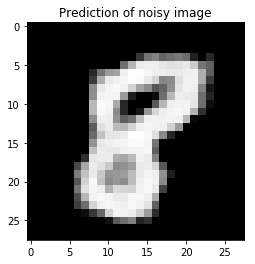

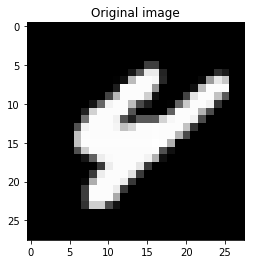

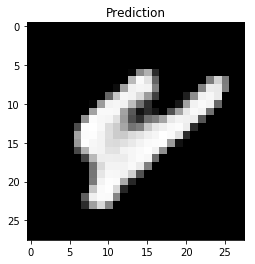

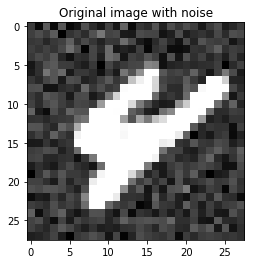

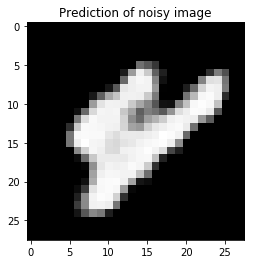

In [7]:
testAutoencoder(learning_rate=0.1, epochs=10000, num_predictions_print=3, test_noise=True)
testAutoencoder(learning_rate=0.01, epochs=10000, num_predictions_print=3, test_noise=True)
testAutoencoder(learning_rate=0.001, epochs=10000, num_predictions_print=3, test_noise=True)